In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

- date_time - время показа рекламы
- zone_id - id зоны, где зона - место на сайте для размещения рекламы
- banner_id - id баннера, где баннер - сама реклама
- campaign_clicks - общее количество показов данной кампании (которой соотвествует баннер) данному юзеру, произошедшие до текущего показа. 
- os_id - id операционной системы
- country_id - id страны
- impressions - был ли показ
- clicks - был ли клик

In [2]:
data = pd.read_csv('data.csv',
                   usecols=['date_time', 'zone_id', 'banner_id', 'campaign_clicks', 
                            'os_id', 'country_id', 'impressions', 'clicks'],
                   parse_dates=['date_time']
                  )
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30,0,0,0,0,0,1,1
1,2021-09-26 22:54:49,1,1,0,0,1,1,1
2,2021-09-26 23:57:20,2,2,3,0,0,1,1
3,2021-09-27 00:04:30,3,3,0,1,1,1,1
4,2021-09-27 00:06:21,4,4,0,1,0,1,1


In [3]:
data.shape

(15821472, 8)

    Посмотрим на категориальные фичи, то есть на все, кроме 'campaign_clicks'.

Check nans:
date_time          0
zone_id            0
banner_id          0
campaign_clicks    0
os_id              0
country_id         0
impressions        0
clicks             0
dtype: int64

zone_id has 3444 different values


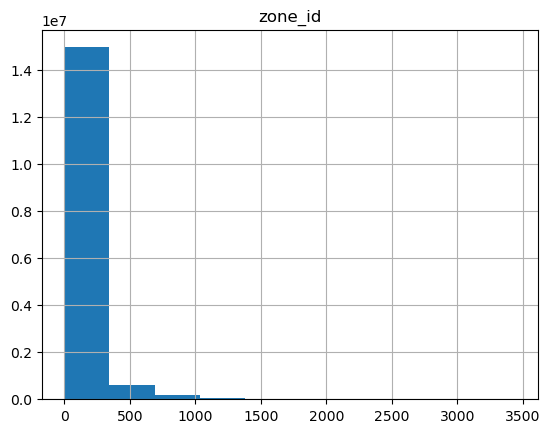


banner_id has 1633 different values


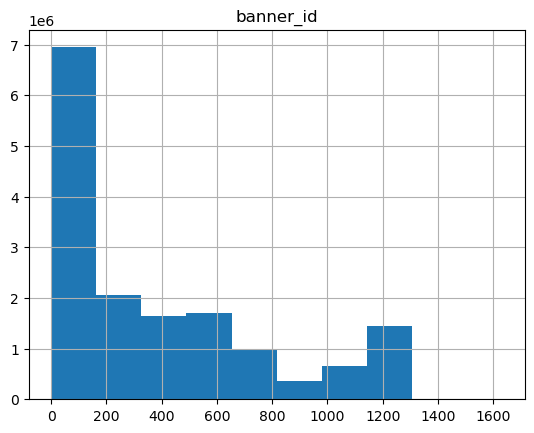


os_id has 11 different values


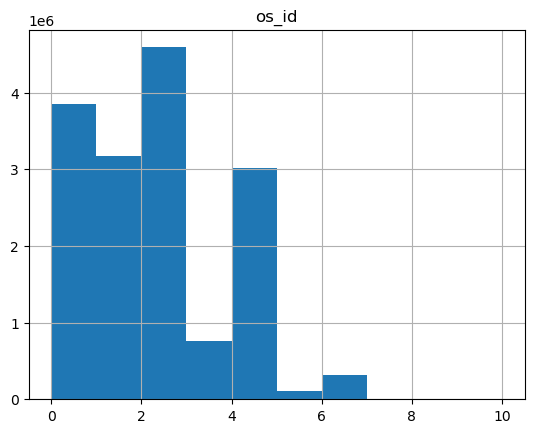


country_id has 17 different values


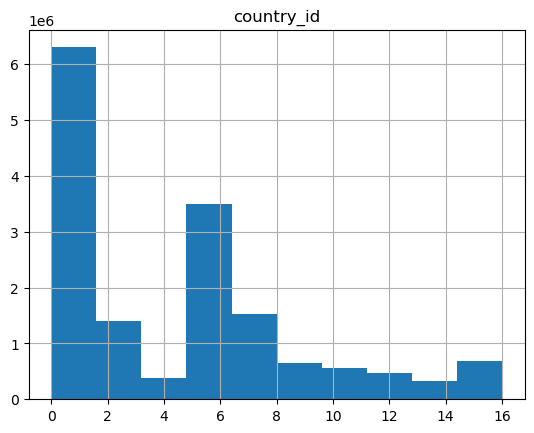


impressions has 1 different values


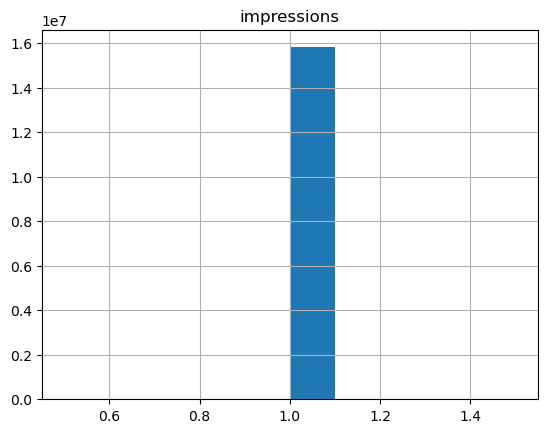


clicks has 2 different values


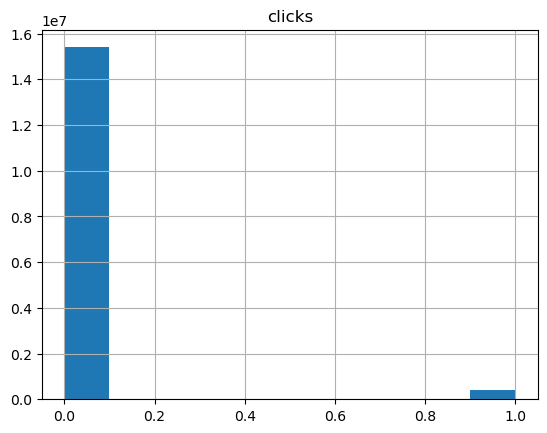



log campaign_clicks values: 


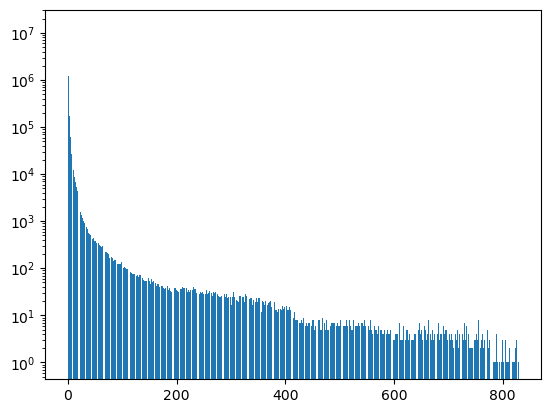


min date: 2021-09-01 00:02:49
max date: 2021-10-02 23:59:59
days values: [ 1  2 26 27 28 29 30]
hours values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


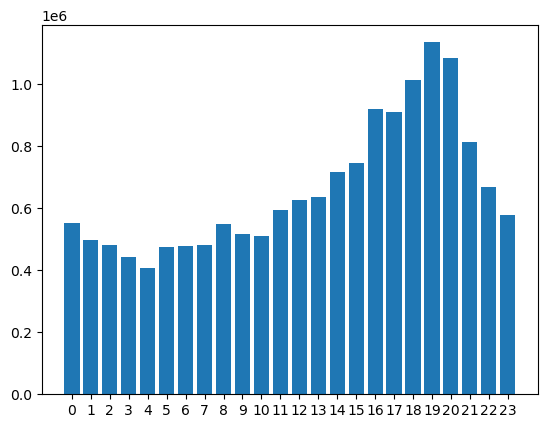

In [4]:
def analysis(df: pd.DataFrame):
    print('Check nans:')
    print(df.isnull().sum(), end='\n\n')

    def columns_desc(column_names):
        for column in column_names:
            if column == 'date_time' or column == 'campaign_clicks':
                continue
            print(f"{column} has {len(np.unique(data[column].values))} different values")
            df.hist(column)
            plt.show()
            print()

    columns_desc(data.columns.values.tolist())

    print("\nlog campaign_clicks values: ")
    x, y = np.unique(data['campaign_clicks'].values, return_counts=True)
    plt.bar(x, y, log=True)
    plt.show()
    
    print(f"\nmin date: {data['date_time'].min()}")
    print(f"max date: {data['date_time'].max()}")
    print(f"days values: {np.unique(data['date_time'].dt.day.values)}")
    print(f"hours values: {np.unique(data['date_time'].dt.hour.values)}")
    x, y = np.unique(data['date_time'].dt.hour.values, return_counts=True)
    plt.bar(x, y, tick_label=[str(val) for val in x])
    plt.show()

analysis(data)

    Разобьем наш датасет.

In [5]:
data_train = data[data['date_time'].dt.date != pd.to_datetime('2021-10-02').date()]
y_train = data_train['clicks']
data_train = data_train.drop('clicks', axis=1)

data_test = data[data['date_time'].dt.date == pd.to_datetime('2021-10-02').date()]
y_test = data_test['clicks']
data_test = data_test.drop('clicks', axis=1)

In [34]:
data_train.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions
0,2021-09-27 00:01:30,0,0,0,0,0,1
1,2021-09-26 22:54:49,1,1,0,0,1,1
2,2021-09-26 23:57:20,2,2,3,0,0,1
3,2021-09-27 00:04:30,3,3,0,1,1,1
4,2021-09-27 00:06:21,4,4,0,1,0,1


In [39]:
data_test.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions
164,2021-10-02 00:01:07,8,76,0,1,3,1
166,2021-10-02 00:00:56,14,46,0,6,0,1
168,2021-10-02 00:04:05,30,76,0,2,3,1
169,2021-10-02 00:04:12,14,46,0,0,0,1
359,2021-10-02 00:01:09,14,2,0,0,0,1


    Видно что даты у нас только за 2021, к тому же за два месяца. Кроме того, если посмотреть на определенные числа в месяце, то их тоже мало.  Хорошо представлены часы, поэтому от 'date_time' оставим только их.

    Поле impressions уберем, так как оно содержит только одно значение.

    К числовой фиче 'campaign_clicks' применим StandardScaler. К остальным - OneHot. 

In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.sparse import hstack

In [9]:
def feature_engineering(train_data: pd.DataFrame, test_data: pd.DataFrame) -> pd.DataFrame:
    # сначала уберем лишние столбцы и добавим часы
    new_train_data = train_data.drop('impressions', axis=1)
    new_train_data['hour'] = train_data['date_time'].dt.hour
    new_train_data = new_train_data.drop('date_time', axis=1)

    new_test_data = test_data.drop('impressions', axis=1)
    new_test_data['hour'] = test_data['date_time'].dt.hour
    new_test_data = new_test_data.drop('date_time', axis=1)

    # применим OneHot
    test_sparse = []
    train_sparse = []

    for column in ['zone_id', 'banner_id',	'os_id', 'country_id', 'hour']:
        encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore').fit(new_train_data[[column]])
        train_encoded = encoder.transform(new_train_data[[column]])
        test_encoded = encoder.transform(new_test_data[[column]])
        train_sparse.append(train_encoded)
        test_sparse.append(test_encoded)

    X_train_sparse = hstack(train_sparse)
    X_test_sparse = hstack(test_sparse)

    # применим скейлер
    scaler = StandardScaler().fit(new_train_data[['campaign_clicks']])
    X_train_dense = scaler.transform(new_train_data[['campaign_clicks']])
    X_test_dense = scaler.transform(new_test_data[['campaign_clicks']])

    X_train = hstack([X_train_sparse, X_train_dense])
    X_test = hstack([X_test_sparse, X_test_dense])

    return X_train, X_test

modified_X_train, modified_X_test = feature_engineering(data_train, data_test)

In [40]:
modified_X_train.shape

(13692494, 4969)

    Для предсказаний будем использовать логистическую регрессию. Заметим, что пока мы не учитывали интеракции.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

    Решать будем логистической регрессией. Для оптимизации выберем sparse алгоритм.

In [11]:
def create_model(C):
    return LogisticRegression(penalty='l2', 
                              C=C,
                              solver='liblinear',
                              verbose=1)#.fit(X, y)

In [12]:
def cv(X, y):
    log_scores = []
    auc_scores = []
    c_params = [0.0001, 0.001, 0.01, 0.1, 1.0]
    for c_param in c_params:
        score = cross_validate(estimator=create_model(c_param), 
                                X=X, y=y, 
                                scoring=['neg_log_loss', 'roc_auc'], 
                                cv=5, 
                                verbose=1)
        log_scores.append(score['test_neg_log_loss'].mean())
        auc_scores.append(score['test_roc_auc'].mean())
    return list(zip(c_params, log_scores, auc_scores))

In [ ]:
cv_scores = cv(modified_X_train, y_train)

    Посмотрим на результаты.

In [15]:
for elem in cv_scores:
    print(f"C={elem[0]}, log_loss={-elem[1]}, auc={elem[2]}")

C=0.0001, log_loss=0.11588592023548605, auc=0.6193209369899015
C=0.001, log_loss=0.11705217717463698, auc=0.6257165843735577
C=0.01, log_loss=0.1188771522887138, auc=0.6343365398325538
C=0.1, log_loss=0.12029584894567143, auc=0.6381733472041492
C=1.0, log_loss=0.12070346227764753, auc=0.6401730832402184


    Выберем C = 1. Разница nll не такая большая.

In [45]:
model = create_model(1)
model.fit(modified_X_train, y_train)

[LibLinear]

LogisticRegression(C=1, solver='liblinear', verbose=1)

    Посчитаем метрики на тестовой выборке.

In [24]:
from sklearn.metrics import log_loss, roc_auc_score

In [46]:
preds = model.predict_proba(modified_X_test)[:, 1]

In [47]:
log_loss(y_test, preds), roc_auc_score(y_test, preds)

(0.13330442699878062, 0.780217651803338)

    Сравним со средним.

In [48]:
baseline = np.full_like(y_test, fill_value=np.mean(y_test))

In [49]:
log_loss(y_test, baseline), roc_auc_score(y_test, baseline)

(1.2758806369585063, 0.5)

    Успех.

    Попробуем теперь с интеракциями.

    Контекстные фичи: 'os_id', 'country_id'
    Рекламные: 'hour', 'zone_id', 'banner_id', 'campaign_clicks'.

    Если использовать декартово произведение, то получится 8 новых фичей - многовато. Лучше подумаем сами, какие интеракции могут быть полезны.
    'os_id' + 'zone_id' - на разных устройствах разные зоны
    'os_id' + 'banner_id' - на разных устройствах может быть релевантна разная реклама
    'country_id' + 'banner_id' - в разных странах может быть релевантна разная реклама

    Дальше я не уверен, что cделал правильно. Я бы перемножил one-hot фичи, но у них скорее всего разные размерности. Поэтому попробую сначала соединить, а потом one-hot.

In [50]:
data_train = data[data['date_time'].dt.date != pd.to_datetime('2021-10-02').date()]
y_train = data_train['clicks']
data_train = data_train.drop('clicks', axis=1)

data_test = data[data['date_time'].dt.date == pd.to_datetime('2021-10-02').date()]
y_test = data_test['clicks']
data_test = data_test.drop('clicks', axis=1)

    Изменим функцию, добавив интеракции.

In [58]:
def feature_engineering(train_data: pd.DataFrame, test_data: pd.DataFrame) -> pd.DataFrame:
    # сначала уберем лишние столбцы, добавим часы и интеракции
    new_train_data = train_data.drop('impressions', axis=1)
    new_train_data['hour'] = train_data['date_time'].dt.hour
    new_train_data = new_train_data.drop('date_time', axis=1)
    new_train_data['os_zone'] = new_train_data['os_id'].astype(str)+'_'+new_train_data['zone_id'].astype(str)
    new_train_data['os_banner'] = new_train_data['os_id'].astype(str)+'_'+new_train_data['banner_id'].astype(str)
    new_train_data['country_banner'] = new_train_data['country_id'].astype(str)+'_'+new_train_data['banner_id'].astype(str)

    new_test_data = test_data.drop('impressions', axis=1)
    new_test_data['hour'] = test_data['date_time'].dt.hour
    new_test_data = new_test_data.drop('date_time', axis=1)
    new_test_data['os_zone'] = new_test_data['os_id'].astype(str)+'_'+new_test_data['zone_id'].astype(str)
    new_test_data['os_banner'] = new_test_data['os_id'].astype(str)+'_'+new_test_data['banner_id'].astype(str)
    new_test_data['country_banner'] = new_test_data['country_id'].astype(str)+'_'+new_test_data['banner_id'].astype(str)

    # применим OneHot
    test_sparse = []
    train_sparse = []

    for column in ['zone_id', 'banner_id',	'os_id', 'country_id', 'hour', 'os_zone', 'os_banner', 'country_banner']:
        encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore').fit(new_train_data[[column]])
        train_encoded = encoder.transform(new_train_data[[column]])
        test_encoded = encoder.transform(new_test_data[[column]])
        train_sparse.append(train_encoded)
        test_sparse.append(test_encoded)

    X_train_sparse = hstack(train_sparse)
    X_test_sparse = hstack(test_sparse)

    # применим скейлер
    scaler = StandardScaler().fit(new_train_data[['campaign_clicks']])
    X_train_dense = scaler.transform(new_train_data[['campaign_clicks']])
    X_test_dense = scaler.transform(new_test_data[['campaign_clicks']])

    X_train = hstack([X_train_sparse, X_train_dense])
    X_test = hstack([X_test_sparse, X_test_dense])

    return X_train, X_test

modified_X_train_with_inter, modified_X_test_with_inter = feature_engineering(data_train, data_test)

    Подберем гиперпараметр.

In [ ]:
cv_scores_with_inter = cv(modified_X_train_with_inter, y_train)

In [60]:
for elem in cv_scores_with_inter:
    print(f"C={elem[0]}, log_loss={-elem[1]}, auc={elem[2]}")

C=0.0001, log_loss=0.11461613274298779, auc=0.6429000944114935
C=0.001, log_loss=0.11565165779599351, auc=0.6468777942089045
C=0.01, log_loss=0.11767891779870635, auc=0.6513087772263869
C=0.1, log_loss=0.11914240715084361, auc=0.6547869744338677
C=1.0, log_loss=0.11970375829653039, auc=0.6558846055152693


    Обучим модель с С = 1.

In [61]:
model_with_inter = create_model(1)
model_with_inter.fit(modified_X_train_with_inter, y_train)

[LibLinear]

LogisticRegression(C=1, solver='liblinear', verbose=1)

    Проверим результаты.

In [62]:
preds_with_inter = model_with_inter.predict_proba(modified_X_test_with_inter)[:, 1]

In [63]:
log_loss(y_test, preds_with_inter), roc_auc_score(y_test, preds_with_inter)

(0.1313701010622904, 0.791968708287408)

    Результаты прошлой модели: (0.13330442699878062, 0.780217651803338).
    То есть результат почти такой же. Возможно, надо было попробовать все интеракции. Или же я неправильно реализовал сами интеракции. 